In [2]:
from dotenv import load_dotenv
import os
import pandas as pd 
import matplotlib.pyplot as plt
from opik import Opik, track
from opik.integrations.langchain import OpikTracer

from langchain.chat_models import init_chat_model
from langchain_core.prompts import PromptTemplate

from typing import TypedDict
from IPython.display import Image, display, HTML

os.environ["OPIK_PROJECT_NAME"] = "capstone-playground"

load_dotenv()

print(os.environ['TAVILY_API_KEY'][:20])
print(os.environ['OPENAI_API_KEY'][:20])
print(os.getenv("OPIK_WORKSPACE"))
print(os.getenv("OPIK_PROJECT_NAME"))

tvly-dev-V8aZJqKSeyA
sk-proj-oSYhDCExsLks
divya-venkatraman
capstone-playground


In [2]:
ai_rmf = pd.read_excel('nist_ai_rmf_playbook.xlsx',sheet_name="Playbook",index_col=0)
#ai_rmf.set_index('Unnamed: 0', inplace=True)
ai_rmf = ai_rmf.transpose()
ai_rmf = ai_rmf.reset_index()
ai_rmf = ai_rmf.rename(columns={'index': 'section_id'})
ai_rmf.head(2)
#ai_rmf.columns
#ai_rmf.to_excel("nist_ai_rmf_playbook_structured.xlsx",index=False)

,section_id,section_about,section_actions,section_doc,section_ref
0,GOVERN 1.1,AI systems may be subject to specific applicab...,* Maintain awareness of the applicable legal a...,### Organizations can document the following\n...,"Andrew Smith, ""Using Artificial Intelligence a..."
1,GOVERN 1.2,"Policies, processes, and procedures are centra...",Organizational AI risk management policies sho...,### Organizations can document the following\n...,"Off. Comptroller Currency, Comptroller’s Handb..."


In [3]:
# looking into only Govern Controls
ai_rmf_govern = ai_rmf[ai_rmf['section_id'].str.contains('GOVERN')]
print(ai_rmf_govern.shape)
ai_rmf_govern.head()

(19, 5)


,section_id,section_about,section_actions,section_doc,section_ref
0,GOVERN 1.1,AI systems may be subject to specific applicab...,* Maintain awareness of the applicable legal a...,### Organizations can document the following\n...,"Andrew Smith, ""Using Artificial Intelligence a..."
1,GOVERN 1.2,"Policies, processes, and procedures are centra...",Organizational AI risk management policies sho...,### Organizations can document the following\n...,"Off. Comptroller Currency, Comptroller’s Handb..."
2,GOVERN 1.3,Risk management resources are finite in any or...,- Establish policies to define mechanisms for ...,### Organizations can document the following\n...,Board of Governors of the Federal Reserve Syst...
3,GOVERN 1.4,Clear policies and procedures relating to docu...,- Establish and regularly review documentation...,### Organizations can document the following\n...,"Bd. Governors Fed. Rsrv. Sys., Supervisory Gui..."
4,GOVERN 1.5,AI systems are dynamic and may perform in unex...,- Establish policies to allocate appropriate r...,### Organizations can document the following\n...,National Institute of Standards and Technology...


Text(0.5, 1.0, 'Distribution of number of words across GOVERN control description')

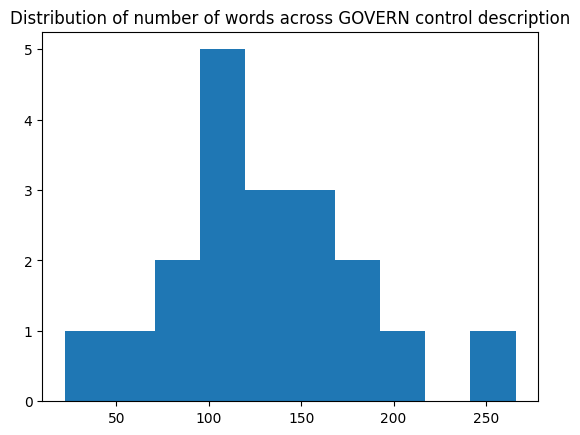

In [5]:
plt.hist(ai_rmf_govern["section_about"].apply(lambda x : len(x.split())));
plt.title("Distribution of number of words across GOVERN control description")

In [6]:
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

# vectorizing only the description and all the section ids, actions & documentations as meta data
documents = []
for _, row in ai_rmf_govern.iterrows():
    doc = Document(
        page_content=row['section_about'],
        metadata={
            'section_id': row['section_id'],
            'section_actions': row['section_actions'],
            'section_doc': row['section_doc']
        }
    )
    documents.append(doc)
# Initialize embeddings model
embedding_model = OpenAIEmbeddings(model='text-embedding-3-small')
# Build the vector store
vector_store = InMemoryVectorStore.from_documents(
    documents=documents,
    embedding=embedding_model
)

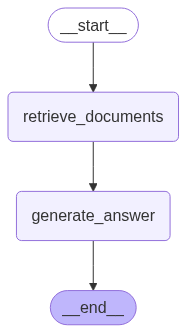

In [22]:
# Create the graph
from langgraph.graph import StateGraph, START, END

retriever = vector_store.as_retriever()
model = init_chat_model("gpt-4o", model_provider="openai")
#model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

class GraphState(TypedDict):
    question: str
    documents: list[str]
    generated_answer: str

def retrieve_documents_with_metadata(state: GraphState):
    docs = retriever.get_relevant_documents(state["question"],k=2)
    return {"documents": docs}

def generate_answer_with_summaryofmetatadata(state: GraphState):
    # Call the model to generate the answer using the retrieved documents
    # and the question
    # Join all the retrieved documents into a single string
    #old code structure
    #prompt = PromptTemplate.from_template(
    #    "Answer the question succintly based on the context provided. \n"
    #    "Question: {question}\n"
    #    "Context: {context}\n"
    #    "Answer: "
    #)
    #context = "\n".join([doc.page_content for doc in state["documents"]])
    #prompt = prompt.format(question=state["question"], context=context)
    #answer = model.invoke(prompt).content

    # Extract content and metadata from documents
    context_blocks = []
    section_ids = []
    actions_list = []
    docs_list = []

    # Sub-prompts for summarizing each section
    
    #action_summarizer = PromptTemplate.from_template(
    #    "Summarize the following actions from NIST AI Risk Management Framework very briefly:\n\n{actions}"
    #)
    action_summarizer = PromptTemplate.from_template(
    """You are analyzing a set of activities related to AI governance and risk management. 
    The following is a list of actions drawn from the section_about portion of a compliance playbook. Igmore all the markdown templates and generate the ouput as plain text.
    Summarize the key actions in a concise and practical manner for an internal compliance or audit team:\n\n{actions}"""
    )
    #doc_summarizer = PromptTemplate.from_template(
    #    "Summarize the documentation expectations gathered from NIST AI Risk Management Framework very briefly:\n\n{doc}"
    #)
    doc_summarizer = PromptTemplate.from_template(
    """You are reviewing documentation guidance extracted from the AI risk management framework. 
    Summarize the types of documents, records, or evidence that should be prepared or maintained. Igmore all the markdown templates and generate the ouput as plain text. 
    Focus on what internal teams (e.g., compliance, risk, audit) should document to demonstrate adherence to AI governance requirements:\n\n{doc}"""
    )  
    for doc in state["documents"]:
        context_blocks.append(doc.page_content)

        # Section ID
        section_id = doc.metadata.get("section_id", "Unknown")
        section_ids.append(section_id)

        # Summarize section_actions
        actions = doc.metadata.get("section_actions", "")
        if actions.strip():
            actions_list.append(actions)

        # Summarize section_doc
        doc_text = doc.metadata.get("section_doc", "")
        if doc_text.strip():
            docs_list.append(doc_text)

    # answer prompt
    answer_template = PromptTemplate.from_template(
        "Answer the question based on the context provided. \n"
        "Question: {question}\n"
        "Context: {context}\n"
        "Answer: "
    )
    formatted_prompt = answer_template.format(
        question=state["question"],
        context="\n\n".join(context_blocks))
    answer = model.invoke(formatted_prompt).content
    
    #summarized_actions = model.invoke(action_summarizer.format(actions="\n".join(actions_list))).content.strip()
    summarized_actions = model.invoke(
    action_summarizer.format_prompt(actions="\n".join(actions_list))
    ).content.strip()
    
    #summarized_docs = model.invoke(action_summarizer.format(doc="\n".join(docs_list))).content.strip()
    summarized_docs = model.invoke(
    doc_summarizer.format_prompt(doc="\n".join(docs_list))
    ).content.strip()

    question = state["question"]
    final_answer_template = f"""
    

    ### Question:
    {question}

    ### Answer:
    {answer}

    ### Relevant Section IDs:
    {section_ids}

    ### Summary of Actions:
    {summarized_actions}

    ### Summary of Documentation Requirements:
    {summarized_docs}

    """

    
    #answer = model.invoke(formatted_prompt).content
    return {"generated_answer": final_answer_template}
    #return {"generated_answer": answer}

graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents_with_metadata)
graph_builder.add_node("generate_answer", generate_answer_with_summaryofmetatadata)

graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_answer")
graph_builder.add_edge("generate_answer", END)

graph = graph_builder.compile()
# Track the graph structure:
tracer = OpikTracer(graph=graph.get_graph(xray=True))
display(Image(graph.get_graph().draw_mermaid_png()))


In [23]:
result = graph.invoke({"question": "How are responsibilities for AI risk management assigned across teams and leadership?"}, config={"callbacks": [tracer]})
print(result["generated_answer"])




    ### Question:
    How are responsibilities for AI risk management assigned across teams and leadership?

    ### Answer:
    Responsibilities for AI risk management across teams and leadership are structured to ensure accountability and effective oversight. Senior leadership and C-Suite members maintain awareness of AI risks, affirm the organization’s risk appetite, and oversee risk management. Specific teams and individuals are held accountable for AI risk management efforts, often facilitated by a designated officer granted authority and resources.

In a risk-aware organizational structure, responsibilities are clearly defined, sometimes with professionals involved in testing and evaluation working independently from AI developers and reporting through risk management functions or directly to executives. This separation helps mitigate biases and strengthens risk management by ensuring it is not ignored or bypassed.

By fostering a culture where AI design and implementation dec

In [10]:
result = graph.invoke({"question": "How frequently are your AI governance policies reviewed and updated?"}, config={"callbacks": [tracer]})
print(result["generated_answer"])


1. **Answer**: The frequency with which AI governance policies are reviewed and updated should correspond to the dynamic and evolving nature of AI systems. As these systems may exhibit unexpected behaviors over time, it is crucial for organizations to continually monitor and assess their AI governance policies. This includes maintaining incident response plans, updating risk management processes, and ensuring that policies reflect current legal standards, industry best practices, and any changes in the operational environment. Regular training and education of personnel involved in AI projects are also essential to ensure they are equipped to manage any arising risks effectively.

2. **Relevant Sections**: 
   - GOVERN 1.5
   - GOVERN 1.2
   - GOVERN 2.2
   - GOVERN 4.3

3. **Action Summary**: 
   - **GOVERN 1.5**: Develop guidelines for resource allocation, monitoring responsibilities, incident handling, and offering recourse for contesting AI outcomes.
   - **GOVERN 1.2**: Establish 

In [18]:
result = graph.invoke({"question": "What artifacts need to go into AI system inventory?"}, config={"callbacks": [tracer]})
print(result["generated_answer"])





    ### Question:
    What artifacts need to go into AI system inventory?

    ### Answer:
    The artifacts that need to go into an AI system inventory include:

1. System documentation.
2. Incident response plans.
3. Data dictionaries.
4. Links to implementation software or source code.
5. Names and contact information for relevant AI actors.
6. Information helpful for model or system maintenance and incident response, such as system limitations or known negative impacts.
7. Information regarding concept drift, AI bias, discrimination, shortcut learning, or underspecification.
8. Testing policies and procedures or results from pre-alpha, pre-beta testing, or other testing phases.
9. Details on how models are being decommissioned and stored.
10. Records of any relevant incidents or issues encountered during system deployment or testing.
11. Updates on compliance with regulatory requirements or any legal concerns.
12. Training curricula related to AI risk management and awareness of